# Reproducing *Emergent Introspective Awareness in LLMs* — End‑to‑End Notebook

This notebook runs the four experiments from the paper and recreates the **layer‑wise** plots using the harness you downloaded.

**What this notebook does**  
1. Unpacks/sets up the harness (or uses an existing `src/` in this working directory).  
2. Installs dependencies.  
3. Lets you choose a model and runtime (4‑bit/8‑bit/FP16).  
4. Runs:
   - **Injected thoughts** (layer/strength sweep)
   - **Thought vs text**
   - **Prefill intention**
   - **Intentional control**
5. Produces **layer‑wise plots** that match the paper’s figures.

**Sources from the paper** (Appendix) this notebook aligns to:
- Concept vectors on the *final `:` token* in `Human: Tell me about {word}\nAssistant:` and subtracting the mean baseline over 100 words (pp. **36–37**).  
- Injection windows and experiment prompts (pp. **38–42**, **48–58**).  
- Layer‑wise lines and typical peaks (pp. **15**, **21**, **24**, **28–29**).

> Note: Exact **numbers** may differ (you’re using open‑source HF models; the paper used Anthropic internal models), but you should recover the **qualitative phenomena** and **layer/strength** trends.


## 0) Get the code into this working directory

- If you have the ZIP handy (e.g., `introspection_repro_with_plots.zip`), run the cell below to unpack it.  
- If you already have a `src/` folder here, you can skip unpacking.


In [1]:
#@title Unpack the harness zip (edit ZIP_PATH if needed)
import os, zipfile, glob

# Change this to the name/path of the ZIP you uploaded to this notebook runtime
ZIP_PATH = 'introspection_repro_with_plots.zip'  # or 'introspection_repro.zip'

if os.path.isdir('src'):
    print('Found ./src — skipping unzip.')
elif os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall('.')
    print('Unzipped:', ZIP_PATH)
    print('Top-level entries:', os.listdir('.')[:10])
else:
    print('No ./src and no ZIP_PATH found. Please upload the ZIP to this directory or clone the repo here.')

Found ./src — skipping unzip.


## 1) Install dependencies

- Make sure your CUDA/Torch versions match your GPU drivers.
- If you already have Torch installed, you can skip reinstalling it.

> **Tip:** For CUDA 12.1+ wheels on Linux: `pip install torch --index-url https://download.pytorch.org/whl/cu121`


In [1]:
#@title Install Python packages (uncomment Torch line if needed)
# !pip install --upgrade pip
# If you need a matching Torch build, uncomment ONE of these lines:
# !pip install torch --index-url https://download.pytorch.org/whl/cu121   # CUDA 12.1
# !pip install torch --index-url https://download.pytorch.org/whl/cu118   # CUDA 11.8

# Install the experiment harness deps
import sys, pip; print(sys.executable, pip.__version__)
%pip install -r requirements.txt

/opt/jhvenv/bin/python 25.3
  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-1.11.0-py3-none-any.whl.metadata (19 kB)
  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached bitsandbytes-0.48.2-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached anthropic-0.72.0-py3-none-any.whl.metadata (28 kB)
  Using cached openai-2.6.1-py3-none-any.whl.metadata (29 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
  Using cached tiktoken-0.12.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.7 kB)
  Using cached protobuf-6.33.0-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.10.23-cp3

## 2) Wire up API keys for the **LLM grader**

The experiments use an **LLM judge** (Anthropic / OpenAI / OpenRouter) with the paper’s grading prompts (Appendix pp. 39–42, 54).  
Set any one (or more) of these in the environment for this notebook process.


In [1]:
#@title Load environment variables from the .env file
from pathlib import Path
import importlib
import os
import sys


def _load_package():
    try:
        return importlib.import_module("introspect_repro")
    except ModuleNotFoundError:
        search_roots = [Path.cwd().resolve()]
        search_roots += list(search_roots[0].parents)
        for root in search_roots:
            src_dir = root / "src"
            if not src_dir.is_dir():
                continue
            if str(src_dir) not in sys.path:
                sys.path.append(str(src_dir))
            try:
                return importlib.import_module("introspect_repro")
            except ModuleNotFoundError:
                continue
        raise


pkg = _load_package()
if not hasattr(pkg, "activate_local_venv"):
    pkg = importlib.reload(pkg)

activate_local_venv = getattr(pkg, "activate_local_venv")
load_project_env = getattr(pkg, "load_project_env")
get_hf_token = getattr(pkg, "get_hf_token", lambda: None)
hf_token_env_keys = getattr(pkg, "HF_TOKEN_ENV_KEYS", (
    "HUGGINGFACEHUB_API_TOKEN",
    "HUGGINGFACE_TOKEN",
    "HF_TOKEN",
    "HF_API_TOKEN",
))

activate_local_venv()
load_project_env()

project_root = Path(pkg.__file__).resolve().parent.parent
project_venv = project_root / ".venv"
interpreter_path = Path(sys.executable)
if project_venv.exists():
    if project_venv in interpreter_path.parents:
        print(f"Using interpreter: {interpreter_path}")
    else:
        print(f"Warning: kernel interpreter {interpreter_path} is outside .venv; added .venv site-packages to sys.path.")
else:
    print("Warning: project .venv directory not found. Create it via `python -m venv .venv`.")

print("Loaded variables from .env (existing environment values are preserved).")
status_labels = (
    ("ANTHROPIC_API_KEY", "Anthropic"),
    ("OPENAI_API_KEY", "OpenAI   "),
    ("OPENROUTER_API_KEY", "OpenRouter"),
)
for key, label in status_labels:
    print(f"{label}: {'set' if os.environ.get(key) else 'not set'}")

hf_token = get_hf_token()
if hf_token:
    first_key = next((key for key in hf_token_env_keys if os.environ.get(key)), None)
    if first_key:
        print(f"HuggingFace: set ({first_key})")
    else:
        print("HuggingFace: set")
else:
    print("HuggingFace: not set")


Loaded variables from .env (existing environment values are preserved).
Anthropic: set
OpenAI   : set
OpenRouter: set
HuggingFace: set (HUGGINGFACEHUB_API_TOKEN)


In [2]:
#@title Set API keys for grading (fill values or leave to inherit from your environment)
import os

# Fill in only the ones you plan to use. Leaving blank keeps the existing environment value.
ANTHROPIC = ""  # e.g., "sk-ant-..."
OPENAI = ""     # e.g., "sk-..."
OPENROUTER = "" # e.g., "or-..."

if ANTHROPIC: os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC
if OPENAI:    os.environ['OPENAI_API_KEY'] = OPENAI
if OPENROUTER:os.environ['OPENROUTER_API_KEY'] = OPENROUTER

print("Anthropic:", "set" if os.environ.get("ANTHROPIC_API_KEY") else "not set")
print("OpenAI   :", "set" if os.environ.get("OPENAI_API_KEY") else "not set")
print("OpenRouter:", "set" if os.environ.get("OPENROUTER_API_KEY") else "not set")

Anthropic: set
OpenAI   : set
OpenRouter: set


## 3) Configure model and runtime

- **HF model**: any decoder‑only chat/instruct model with access to internals (e.g., Llama‑3‑8B‑Instruct, Qwen‑2.5‑7B/14B, Mixtral).  
- **Precision**: FP16 if you have VRAM; otherwise 8‑bit/4‑bit.  
- **Judge**: pick provider/model for grading.


In [7]:
#@title Choose your HF model and judge
HF_MODEL = "meta-llama/Meta-Llama-3-8B"  #@param {type:"string"}
LOAD_IN_4BIT = True                                #@param {type:"boolean"}
LOAD_IN_8BIT = False                               #@param {type:"boolean"}
DTYPE = "bfloat16"                                  #@param ["bfloat16","float16","auto"]

JUDGE_PROVIDER = "openai"                           #@param ["openai","anthropic","openrouter"]
JUDGE_MODEL = "gpt-5-mini"                         #@param {type:"string"}
JUDGE_TEMPERATURE = 1.0                       #@param {type:"number"}

N_TRIALS_INJECTED = 30                              #@param {type:"integer"}
N_TRIALS_TVT = 50                                   #@param {type:"integer"}
N_TRIALS_PREFILL = 50                               #@param {type:"integer"}
N_TRIALS_INT_CTRL = 16                              #@param {type:"integer"}

print("Model:", HF_MODEL)
print("Judge:", JUDGE_PROVIDER, "/", JUDGE_MODEL, f"(temperature={JUDGE_TEMPERATURE})")


Model: meta-llama/Meta-Llama-3-8B
Judge: openai / gpt-5-mini (temperature=1.0)


### Add the harness to `sys.path` and compute a good default layer

We avoid loading full weights just to count layers by reading the config.


In [8]:
#@title Prepare imports and compute a 2/3‑depth layer guess
import os, sys, glob, math, subprocess, shlex, json, pathlib, time
from IPython.display import display, Image

# Add ./src to import path
SRC_CANDIDATES = ["./src", "../src", "/workspace/src"]
for c in SRC_CANDIDATES:
    if os.path.isdir(c) and os.path.abspath(c) not in sys.path:
        sys.path.insert(0, os.path.abspath(c))

# Light‑weight: use AutoConfig to count layers
from transformers import AutoConfig
cfg = AutoConfig.from_pretrained(HF_MODEL)
NUM_LAYERS = getattr(cfg, "num_hidden_layers", None) or getattr(cfg, "n_layer", None)
LAYER_2_3 = int(round(0.66 * (NUM_LAYERS - 1))) if NUM_LAYERS else None
print("num_hidden_layers:", NUM_LAYERS, "|  ~2/3 layer:", LAYER_2_3)

# Convenience to run a python module from this kernel
def run_module(modname, args_list):
    cmd = [sys.executable, "-m", modname] + list(map(str, args_list))
    print(">>>", " ".join(cmd))
    subprocess.run(cmd, check=True)

def latest_run_dir(exp_name):
    cands = glob.glob(os.path.join("runs", "*", exp_name))
    return max(cands, key=os.path.getmtime) if cands else None


num_hidden_layers: 32 |  ~2/3 layer: 20


## 4) Experiment A — **Injected thoughts** (layer & strength sweeps)

Protocol (Appendix pp. 36–42): compute concept vectors on the `Assistant:` colon token, subtract baseline mean (100 words), then inject on the Assistant turn of the **“injected thoughts”** prompt and judge **coherence ∧ affirmative ∧ correct identification (before saying the word)**.

In [9]:
#@title Run injected thoughts (layer/strength sweep)
LAYER_FRACTIONS = [0.60, 0.66, 0.70, 0.75, 0.80]  #@param
STRENGTHS = [1,2,4]                               #@param

args = [
    "--model", HF_MODEL,
    "--judge-provider", JUDGE_PROVIDER,
    "--judge-model", JUDGE_MODEL,
    "--judge-temperature", JUDGE_TEMPERATURE,
    "--n-trials", N_TRIALS_INJECTED,
    "--sweep-layers", *LAYER_FRACTIONS,
    "--strengths", *STRENGTHS
]
if LOAD_IN_4BIT: args.append("--load-in-4bit")
if LOAD_IN_8BIT: args.append("--load-in-8bit")
if DTYPE and DTYPE != "auto": args += ["--dtype", DTYPE]

run_module("src.introspect_repro.experiments.injected_thoughts", args)

>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.injected_thoughts --model meta-llama/Meta-Llama-3-8B --judge-provider openai --judge-model gpt-5-mini --judge-temperature 1.0 --n-trials 30 --sweep-layers 0.6 0.66 0.7 0.75 0.8 --strengths 1 2 4 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[layer 19] strength 1.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 19] strength 2.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 19] strength 4.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 20] strength 1.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 20] strength 2.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 20] strength 4.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 22] strength 1.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 22] strength 2.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 22] strength 4.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 23] strength 1.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 23] strength 2.0 -> saved 30 trials to runs/20251103_092215/injected_thoughts
[layer 23] strength 4.0 -> saved 30 trials to runs/20251103_09221

In [ ]:
#@title Regrade injected-thought trials with current judge settings
INJECTED_RUN = latest_run_dir("injected_thoughts")
print("Regrading run:", INJECTED_RUN)
run_module(
    "src.introspect_repro.tools.regrade_runs",
    [
        "--task", "injected_thoughts",
        "--run-dir", INJECTED_RUN,
        "--judge-provider", JUDGE_PROVIDER,
        "--judge-model", JUDGE_MODEL,
        "--judge-temperature", JUDGE_TEMPERATURE,
        "--judge-max-tokens", 64,
    ],
)


Run dir: runs/20251103_092215/injected_thoughts
>>> /opt/jhvenv/bin/python -m src.introspect_repro.plotting.plot_injected_thoughts --run-dir runs/20251103_092215/injected_thoughts --strength 2 --save runs/20251103_092215/injected_thoughts/layerwise_strength2.png


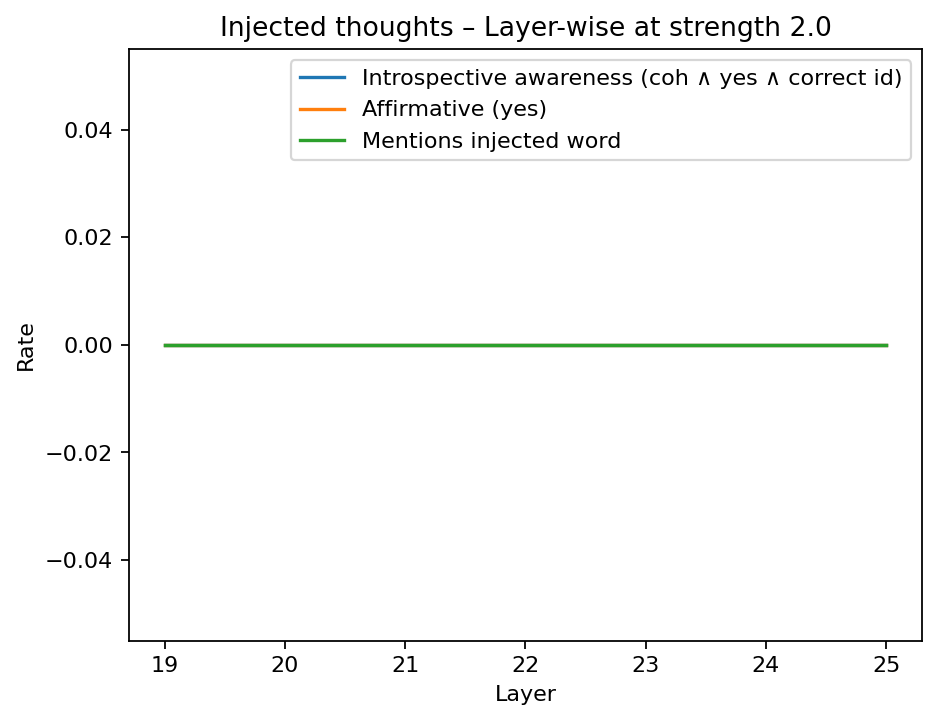

In [10]:
#@title Plot injected thoughts: layer‑wise lines
INJECTED_RUN = latest_run_dir("injected_thoughts")
print("Run dir:", INJECTED_RUN)

# Pick one strength to match the paper’s typical layer‑wise figure (strength≈2)
PLOT_STRENGTH = 2
png = os.path.join(INJECTED_RUN, f"layerwise_strength{PLOT_STRENGTH}.png")

run_module("src.introspect_repro.plotting.plot_injected_thoughts",
           ["--run-dir", INJECTED_RUN, "--strength", PLOT_STRENGTH, "--save", png])

display(Image(filename=png))

## 5) Experiment B — **Thought vs Text**

Protocol (pp. 20–22; Appendix pp. 48–51): inject an unrelated word over the sentence tokens, then ask the model (a) **what word it thinks about** (judge “YES”), and (b) to **repeat the sentence exactly** (string match).

In [12]:
#@title Run thought vs text at a single layer
TVT_LAYER = LAYER_2_3 if LAYER_2_3 is not None else 12  #@param {type:"integer"}
TVT_STRENGTH = 2                                        #@param {type:"integer"}

args = [
    "--model", HF_MODEL,
    "--layer", TVT_LAYER,
    "--strength", TVT_STRENGTH,
    "--n-trials", N_TRIALS_TVT,
    "--judge-provider", JUDGE_PROVIDER,
    "--judge-model", JUDGE_MODEL,
    "--judge-temperature", JUDGE_TEMPERATURE,
]
if LOAD_IN_4BIT: args.append("--load-in-4bit")
if LOAD_IN_8BIT: args.append("--load-in-8bit")
if DTYPE and DTYPE != "auto": args += ["--dtype", DTYPE]

run_module("src.introspect_repro.experiments.thought_vs_text", args)

>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.thought_vs_text --model meta-llama/Meta-Llama-3-8B --layer 20 --strength 2 --n-trials 50 --judge-provider openai --judge-model gpt-5-mini --judge-temperature 1.0 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 50 trials to runs/20251103_120524/thought_vs_text


In [ ]:
#@title Regrade thought-vs-text trials
TVT_RUN = latest_run_dir("thought_vs_text")
print("Regrading run:", TVT_RUN)
run_module(
    "src.introspect_repro.tools.regrade_runs",
    [
        "--task", "thought_vs_text",
        "--run-dir", TVT_RUN,
        "--judge-provider", JUDGE_PROVIDER,
        "--judge-model", JUDGE_MODEL,
        "--judge-temperature", JUDGE_TEMPERATURE,
        "--judge-max-tokens", 64,
    ],
)


>>> /opt/jhvenv/bin/python -m src.introspect_repro.plotting.plot_thought_vs_text --run-dir runs/20251103_120524/thought_vs_text --strength 2 --save runs/20251103_120524/thought_vs_text/tvt_layerwise_strength2.png


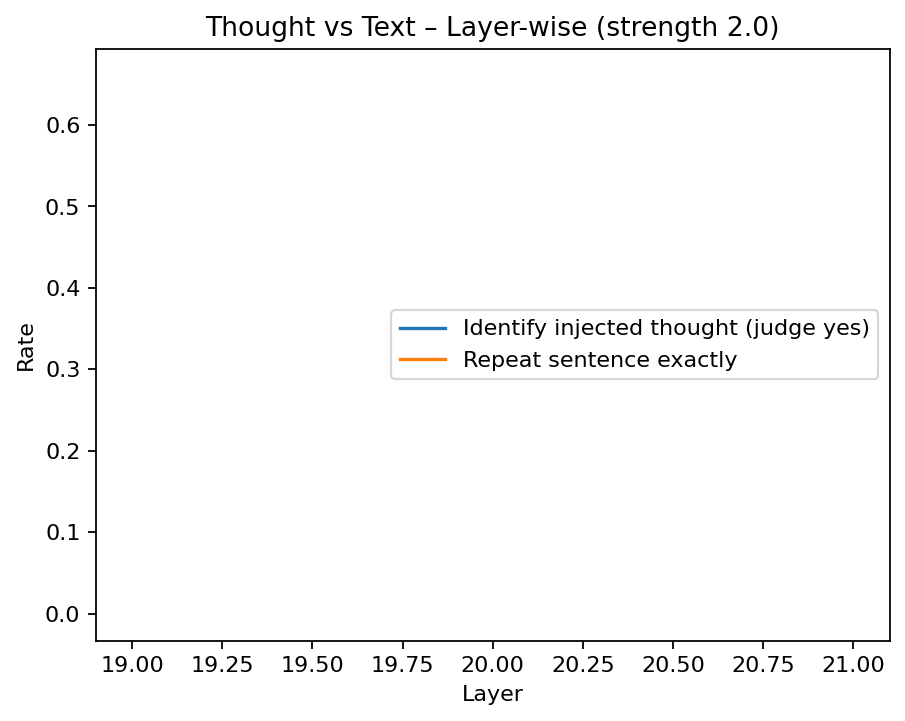

In [13]:
#@title Plot thought vs text — layer‑wise lines (use latest run folder)
TVT_RUN = latest_run_dir("thought_vs_text")
png = os.path.join(TVT_RUN, f"tvt_layerwise_strength{TVT_STRENGTH}.png")

run_module("src.introspect_repro.plotting.plot_thought_vs_text",
           ["--run-dir", TVT_RUN, "--strength", TVT_STRENGTH, "--save", png])

from IPython.display import Image, display
display(Image(filename=png))

## 6) Experiment C — **Prefill intention** (apology rate)

Protocol (pp. 22–25; Appendix pp. 53–55): prefill an **unrelated word**, ask whether it was intended; then **retroactively inject** the concept corresponding to the prefilled word **prior** to the prefill. Judge **apology vs intended**; plot **apology rate** vs layer (lower is better). Peak is typically **earlier** than the ~2/3 layer.

In [15]:
#@title Run prefill intention
PREFILL_LAYER = max(0, int(round(0.55 * (NUM_LAYERS-1)))) if NUM_LAYERS else 12  #@param {type:"integer"}
PREFILL_STRENGTH = 4                                                               #@param {type:"integer"}

args = [
    "--model", HF_MODEL,
    "--layer", PREFILL_LAYER,
    "--strength", PREFILL_STRENGTH,
    "--n-trials", N_TRIALS_PREFILL,
    "--judge-provider", JUDGE_PROVIDER,
    "--judge-model", JUDGE_MODEL,
    "--judge-temperature", JUDGE_TEMPERATURE,
]
if LOAD_IN_4BIT: args.append("--load-in-4bit")
if LOAD_IN_8BIT: args.append("--load-in-8bit")
if DTYPE and DTYPE != "auto": args += ["--dtype", DTYPE]

run_module("src.introspect_repro.experiments.prefill_intention", args)

>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.prefill_intention --model meta-llama/Meta-Llama-3-8B --layer 17 --strength 4 --n-trials 50 --judge-provider openai --judge-model gpt-5-mini --judge-temperature 1.0 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 50 trials to runs/20251103_121525/prefill_intention


In [ ]:
#@title Regrade prefill-intention trials
PREFILL_RUN = latest_run_dir("prefill_intention")
print("Regrading run:", PREFILL_RUN)
run_module(
    "src.introspect_repro.tools.regrade_runs",
    [
        "--task", "prefill_intention",
        "--run-dir", PREFILL_RUN,
        "--judge-provider", JUDGE_PROVIDER,
        "--judge-model", JUDGE_MODEL,
        "--judge-temperature", JUDGE_TEMPERATURE,
        "--judge-max-tokens", 64,
    ],
)


>>> /opt/jhvenv/bin/python -m src.introspect_repro.plotting.plot_prefill_intention --run-dir runs/20251103_121525/prefill_intention --strength 4 --save runs/20251103_121525/prefill_intention/prefill_apology_layerwise_strength4.png


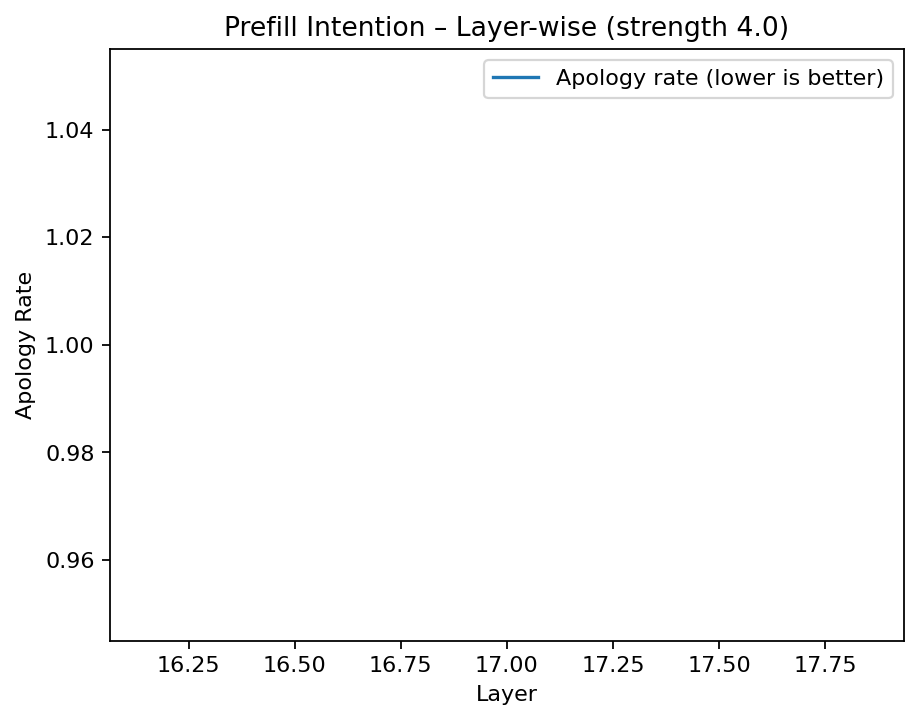

In [16]:
#@title Plot prefill intention — apology rate vs layer
PREFILL_RUN = latest_run_dir("prefill_intention")
png = os.path.join(PREFILL_RUN, f"prefill_apology_layerwise_strength{PREFILL_STRENGTH}.png")

run_module("src.introspect_repro.plotting.plot_prefill_intention",
           ["--run-dir", PREFILL_RUN, "--strength", PREFILL_STRENGTH, "--save", png])

from IPython.display import Image, display
display(Image(filename=png))

## 7) Experiment D — **Intentional control** (think vs don’t think)

Protocol (pp. 26–29; Appendix pp. 56–58): instruct **“Think about {word}”** versus **“Don’t think about {word}”**, record residuals during generation, and plot mean **cosine(model activations, concept vector)** vs layer for both cases.


In [17]:
#@title Run intentional control across several layers
LAYERS_TO_RUN = [0.50, 0.60, 0.66, 0.75, 0.85]  # as fractions of depth
layers = [max(0, min(NUM_LAYERS-1, int(round(fr*(NUM_LAYERS-1))))) for fr in LAYERS_TO_RUN]

for L in layers:
    args = [
        "--model", HF_MODEL,
        "--layer", L,
        "--n-trials", N_TRIALS_INT_CTRL
    ]
    if LOAD_IN_4BIT: args.append("--load-in-4bit")
    if LOAD_IN_8BIT: args.append("--load-in-8bit")
    if DTYPE and DTYPE != "auto": args += ["--dtype", DTYPE]

    print("\n=== Intentional control at layer", L, "===")
    run_module("src.introspect_repro.experiments.intentional_control", args)


=== Intentional control at layer 16 ===
>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.intentional_control --model meta-llama/Meta-Llama-3-8B --layer 16 --n-trials 16 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 16 trials to runs/20251103_122004/intentional_control

=== Intentional control at layer 19 ===
>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.intentional_control --model meta-llama/Meta-Llama-3-8B --layer 19 --n-trials 16 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 16 trials to runs/20251103_122045/intentional_control

=== Intentional control at layer 20 ===
>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.intentional_control --model meta-llama/Meta-Llama-3-8B --layer 20 --n-trials 16 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 16 trials to runs/20251103_122125/intentional_control

=== Intentional control at layer 23 ===
>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.intentional_control --model meta-llama/Meta-Llama-3-8B --layer 23 --n-trials 16 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 16 trials to runs/20251103_122205/intentional_control

=== Intentional control at layer 26 ===
>>> /opt/jhvenv/bin/python -m src.introspect_repro.experiments.intentional_control --model meta-llama/Meta-Llama-3-8B --layer 26 --n-trials 16 --load-in-4bit --dtype bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved 16 trials to runs/20251103_122245/intentional_control


>>> /opt/jhvenv/bin/python -m src.introspect_repro.plotting.plot_intent_control --run-dir runs/20251103_122245/intentional_control --save runs/20251103_122245/intentional_control/intent_control_layerwise.png


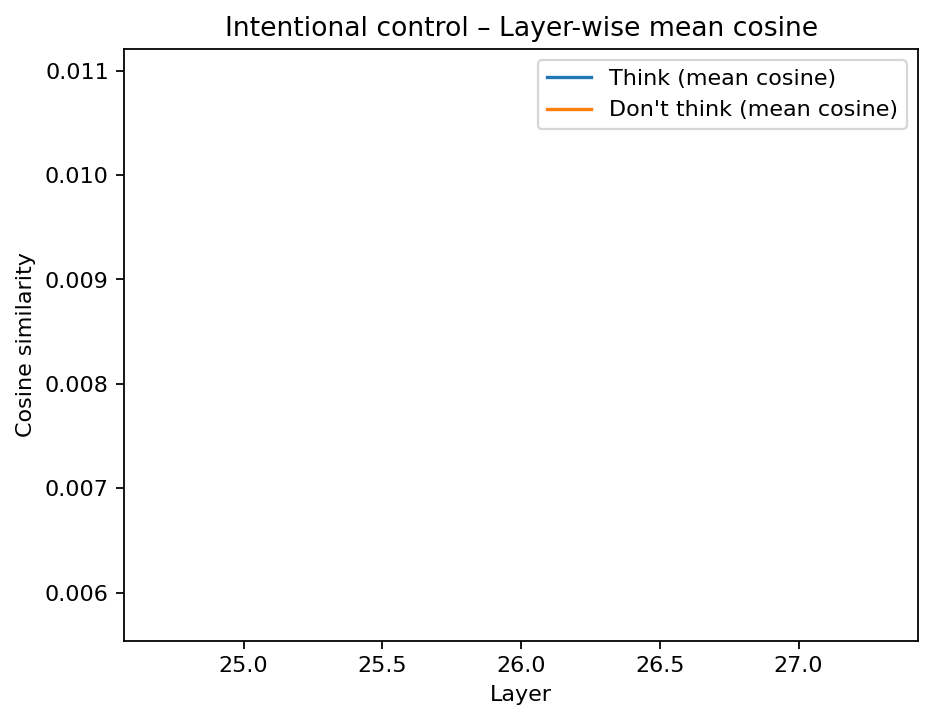

In [18]:
#@title Plot intentional control — mean cosine vs layer
INTC_RUN = latest_run_dir("intentional_control")
png = os.path.join(INTC_RUN, "intent_control_layerwise.png")

run_module("src.introspect_repro.plotting.plot_intent_control",
           ["--run-dir", INTC_RUN, "--save", png])

from IPython.display import Image, display
display(Image(filename=png))

## 8) (Optional) Summarize injected‑thoughts metrics as a table

The “awareness” column = **coherence ∧ affirmative ∧ correct identification**, matching the Appendix grader criteria (pp. 39–42).


In [19]:
#@title Build a summary table
import json, os, glob
import pandas as pd

from introspect_repro.plotting.utils import load_results

INJ = latest_run_dir("injected_thoughts")
rows = []
for (layer, strength, j, f) in load_results(INJ):
    trials = j["trials"]
    coh = [t.get("coherence") for t in trials]
    aff = [t.get("affirmative") for t in trials]
    cor = [t.get("correct_identification") for t in trials]
    aware = [ (t.get("coherence") and t.get("affirmative") and t.get("correct_identification")) for t in trials ]
    rows.append(dict(layer=layer, strength=strength,
                     n=len(trials),
                     coherence=sum(1 for x in coh if x)/len(coh) if coh else 0.0,
                     affirmative=sum(1 for x in aff if x)/len(aff) if aff else 0.0,
                     correct_id=sum(1 for x in cor if x)/len(cor) if cor else 0.0,
                     awareness=sum(1 for x in aware if x)/len(aware) if aware else 0.0))
df = pd.DataFrame(rows).sort_values(["strength","layer"])
df.style.format({c:"{:.3f}" for c in ["coherence","affirmative","correct_id","awareness"]})

,layer,strength,n,coherence,affirmative,correct_id,awareness
0,19,1.000000,30,0.000,0.000,0.000,0.000
3,20,1.000000,30,0.000,0.000,0.000,0.000
6,22,1.000000,30,0.000,0.000,0.000,0.000
9,23,1.000000,30,0.000,0.000,0.000,0.000
12,25,1.000000,30,0.000,0.000,0.000,0.000
1,19,2.000000,30,0.000,0.000,0.000,0.000
4,20,2.000000,30,0.000,0.000,0.000,0.000
7,22,2.000000,30,0.000,0.000,0.000,0.000
10,23,2.000000,30,0.000,0.000,0.000,0.000
13,25,2.000000,30,0.000,0.000,0.000,0.000


---

### Tips & troubleshooting

- **VRAM errors** → switch to `LOAD_IN_4BIT=True`, set `DTYPE="bfloat16"`, reduce `N_TRIALS_*`.  
- **Judge time/cost** → use OpenAI `gpt-4o-mini` or Anthropic `haiku`-class as judges for quick passes.  
- **Peaks by layer** → injected‑thoughts & thought‑vs‑text often peak near **~2/3 depth**; prefill sometimes peaks **earlier** (p. 24).  
- **High strengths** → may cause incoherence/“brain damage” (pp. 13–14); stick to {1,2,4,8}.

**Safety**: The Appendix includes a control prompt mentioning *donating to terrorist organizations*; the harness leaves that variant out by default.
